#The Environmental Context of Fire Severity: Global Patterns and Insights

This section focuses on building and comparing machine learning models to predict wildfire severity based on fire history, seasonal progress, and environmental indicators. The goal is to identify which variables most influence fire size and assess how well different models capture these relationships.

Data Source: Pan, T. (2025). Global wildfire exposure dataset (1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.15254187

In [ ]:
#imports

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [ ]:
fire_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_fire_data.csv')
fire_df.head()

,lat_mean,lon_mean,fwi,vpd,ndvi,months_since_last_fire,season_progress,veg_stress,fires_per_year_country,severity
0,31.193833,61.877793,58.090416,4.113854,0.291094,14.609539,0.166667,2.916336,17,1
1,31.255357,61.884021,58.090416,4.113854,0.291094,0.000000,0.166667,2.916336,17,0
2,31.261574,61.763814,58.090416,4.113854,0.291094,1.578947,0.250000,2.916336,17,1
3,31.191667,61.952393,58.090416,4.113854,0.291094,3.585526,0.583333,2.916336,17,0
4,31.106731,61.986938,58.090416,4.113854,0.291094,0.164474,0.583333,2.916336,17,1


### Define Features and Target

In [ ]:
X = fire_df.drop(columns=['severity'])
y = fire_df['severity']

## Modeling

In [ ]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

Logistic Regression was choosen as the baseline model. It simplicity and interpretability will act as a good starting point in this process.

In [ ]:
#scale data for logistic regression
scaler = StandardScaler()

#fit on training data only, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#train lr model
logreg = LogisticRegression(solver='lbfgs', class_weight = 'balanced')

#fit model
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
#lr accuracy on training set
logreg.score(X_train_scaled, y_train)

0.4119829884874493

In [ ]:
#get predictions for lr
y_pred_lr = logreg.predict(X_test_scaled)


In [ ]:
#accuracy on lr test set
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

Accuracy: 0.4120826037075056


Model accuracy lowered by including class_weight = 'balanced' by 16%, but then the model never predicts class 2 (large fire). Decided to include class_weight eventhough it lowers accuracy, otherwise the model is just guessing, not finding any predictive features.

In [ ]:
#classification report for lr model
print(classification_report(y_test, y_pred_lr, target_names=['small', 'medium', 'big']))

              precision    recall  f1-score   support

       small       0.62      0.54      0.57    207516
      medium       0.39      0.20      0.27    133454
         big       0.10      0.49      0.17     23372

    accuracy                           0.41    364342
   macro avg       0.37      0.41      0.34    364342
weighted avg       0.50      0.41      0.44    364342



Despite having the lowest accuracy, class 2 (big fires) has the highest big fire recall score of any model at almost 50%. Meanwhile the recall for the other two classes is poor comparatively.

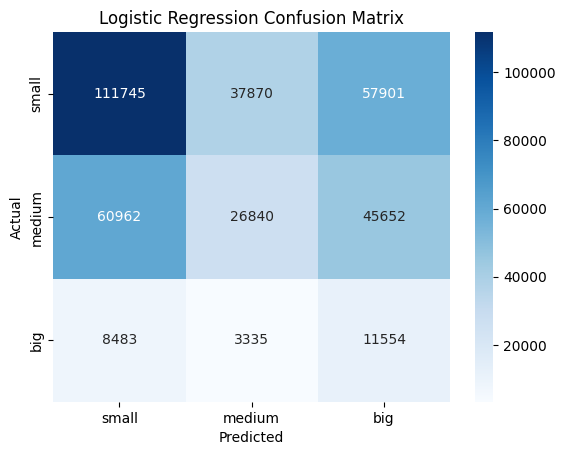

In [ ]:
# lr confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


- Bigger fires predicted much more than other models
- Medium is being misclassified in both directions

In [ ]:
#get feature importances from logistic regression model
coefs = logreg.coef_

feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef_small_vs_rest": coefs[0],
    "coef_medium_vs_rest": coefs[1],
    "coef_big_vs_rest": coefs[2]
})

feature_importance_df

,feature,coef_small_vs_rest,coef_medium_vs_rest,coef_big_vs_rest
0,lat_mean,-0.068656,-0.008359,0.077016
1,lon_mean,-0.116944,-0.033684,0.150627
2,fwi,0.038543,0.016544,-0.055087
3,vpd,0.077310,0.272924,-0.350233
4,ndvi,0.088357,-0.136067,0.047710
5,months_since_last_fire,0.008396,-0.011620,0.003223
6,season_progress,-0.010088,0.026298,-0.016211
7,veg_stress,-0.141427,-0.357771,0.499197
8,fires_per_year_country,-0.092147,-0.029599,0.121746


In [ ]:
#sorted lr feature importance
feature_importance_df["abs_big_coef"] = feature_importance_df["coef_big_vs_rest"].abs()
feature_importance_sorted = feature_importance_df.sort_values(
    by="abs_big_coef",
    ascending=False
)

feature_importance_sorted

,feature,coef_small_vs_rest,coef_medium_vs_rest,coef_big_vs_rest,abs_big_coef
7,veg_stress,-0.141427,-0.357771,0.499197,0.499197
3,vpd,0.077310,0.272924,-0.350233,0.350233
1,lon_mean,-0.116944,-0.033684,0.150627,0.150627
8,fires_per_year_country,-0.092147,-0.029599,0.121746,0.121746
0,lat_mean,-0.068656,-0.008359,0.077016,0.077016
2,fwi,0.038543,0.016544,-0.055087,0.055087
4,ndvi,0.088357,-0.136067,0.047710,0.047710
6,season_progress,-0.010088,0.026298,-0.016211,0.016211
5,months_since_last_fire,0.008396,-0.011620,0.003223,0.003223


- Interestingly, this model does rely more on environmental features than decision tree
- VPD (air dryness) decreases likelihood of big fire, which seems counterintuitive
- FWI and NDVI are still weak predictors, but months since last fire (which is the highest predictor for decision tree) is even lower  

---



### Decision Tree

In [ ]:
#train the decision tree
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth= 12, #12 gets 60.7% accuracy
    random_state=42
)

#fit model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [ ]:
#accuracy on training set (dt)
dt.score(X_train, y_train)

0.6151817731441519

In [ ]:
#get dt predictions
y_pred_dt = dt.predict(X_test)

In [ ]:
#evaluate test set (dt)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

Accuracy: 0.6073881133660133


The following parameters produced no model improvement:
- min_samples_split=20,       
- min_samples_leaf=10,        
- max_features='sqrt',        
- class_weight='balanced' (lowered accuracy by 9%)
- ccp_alpha=0.001
- max depth = 8, 10, 14 (lowered accuracy, 10 was the second best performing)

In [ ]:
#dt classification report
print("\n Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt, target_names=['small', 'medium', 'big']))


 Decision Tree Classification Report:
               precision    recall  f1-score   support

       small       0.65      0.84      0.73    207516
      medium       0.50      0.34      0.41    133454
         big       0.41      0.08      0.13     23372

    accuracy                           0.61    364342
   macro avg       0.52      0.42      0.42    364342
weighted avg       0.58      0.61      0.57    364342



- Model performs best on small fires (recall = 0.84), likely guessing since it is the largest class
- Medium fires frequently misclassified as small
- Large fires are rarely correctly identified (recall = 0.08)


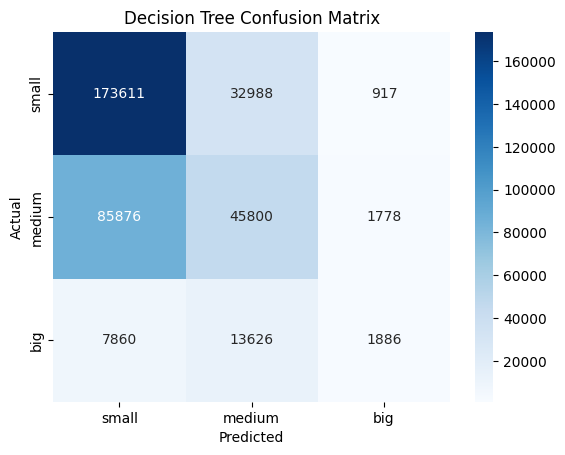

In [ ]:
#dt confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [ ]:
#dt feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance)


                  feature  importance
5  months_since_last_fire    0.390635
1                lon_mean    0.201423
0                lat_mean    0.179029
6         season_progress    0.091849
8  fires_per_year_country    0.049478
2                     fwi    0.029888
4                    ndvi    0.028334
3                     vpd    0.018695
7              veg_stress    0.010669


Model relies very little on environmental variables

### Decision Tree with Class Weight Parameter

While omitting the class weight parameter does increase accuracy, I am curious to see how it improves recall (as we see is the case for Logistic Regression). Additionally I want to see if this parameter will change feature importance.

In [ ]:
#train the second decision tree
dt2 = DecisionTreeClassifier(
    criterion='gini',
    max_depth= 12,
    class_weight='balanced',
    random_state=42
)

#fit model
dt2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42)

In [ ]:
#get dt2 predictions
y_pred_dt2 = dt2.predict(X_test)

In [ ]:
#evaluate test set (dt2)
print("Accuracy:", accuracy_score(y_test, y_pred_dt2))

Accuracy: 0.5167068303956173


In [ ]:
#dt2 classification report
print("\n Decision Tree (cw) Classification Report:\n", classification_report(y_test, y_pred_dt2, target_names=['small', 'medium', 'big']))


 Decision Tree Classification Report:
               precision    recall  f1-score   support

       small       0.69      0.66      0.68    207516
      medium       0.45      0.26      0.33    133454
         big       0.18      0.70      0.29     23372

    accuracy                           0.52    364342
   macro avg       0.44      0.54      0.43    364342
weighted avg       0.57      0.52      0.52    364342



- Produces very similar results to Random Forest and Gradient Boosting, indicating consistent class structure in the data

- Recall on big fires is high (0.70) but with lower generalization and potentially more overfitting

- Medium class remains difficult (recall 0.26)

- Simpler model but less robust compared to ensemble methods

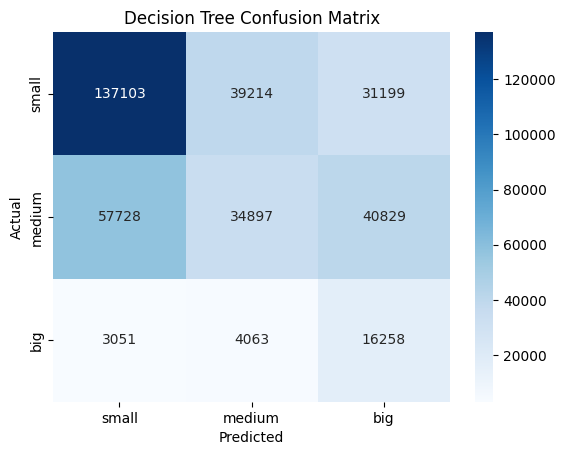

In [ ]:
#dt2 confusion matrix
cm = confusion_matrix(y_test, y_pred_dt2)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

- small is predicted when it is actually big at a smaller rate than the previous decision tree
- both classes are being confused for medium at a higher rate than before, but in exchange bigger fires are predicted at a much higher rate

In [ ]:
#dt2 feature importance
feature_importance_dt2 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt2.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance_dt2)

                  feature  importance
5  months_since_last_fire    0.378754
1                lon_mean    0.253821
0                lat_mean    0.184018
6         season_progress    0.068384
8  fires_per_year_country    0.038585
4                    ndvi    0.029867
7              veg_stress    0.027767
2                     fwi    0.010850
3                     vpd    0.007955


Feature importance is only partially changed from the previous decision tree, and remains very different than logistic regression.

### Random Forest

In [ ]:
#train random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
)

#fit random forest
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

In [ ]:
#accuracy on training set (rf)
rf.score(X_train, y_train)

0.6114442082496778

In [ ]:
#get rf predictions
y_pred_rf = rf.predict(X_test)

In [ ]:
#evaluate random forest
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.6087906417596654


In [ ]:
#classification report for rf
print("\n Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=['small', 'medium', 'big']))


 Random Forest Classification Report:
               precision    recall  f1-score   support

       small       0.64      0.87      0.74    207516
      medium       0.50      0.31      0.38    133454
         big       0.48      0.02      0.04     23372

    accuracy                           0.61    364342
   macro avg       0.54      0.40      0.39    364342
weighted avg       0.58      0.61      0.56    364342



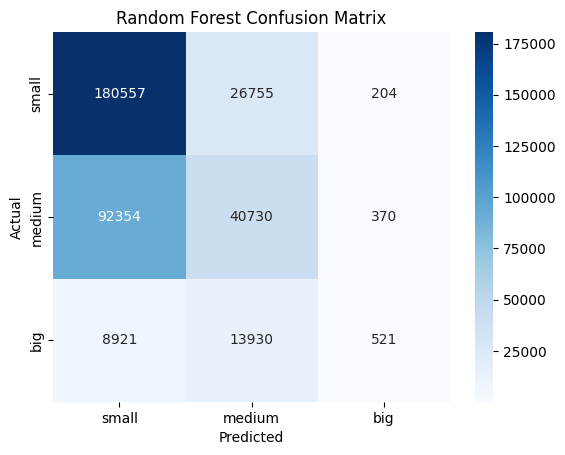

In [ ]:
#confusion matrix for rf
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

The same pattern, accuracy is high, but big fires are rarely predicted.

### Random Forest with Class Weight Parameter

In [ ]:
#train random forest with class weight
rf2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight = 'balanced',
    random_state=42,
)

#fit random forest
rf2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       random_state=42)

In [ ]:
#get rf2 predictions
y_pred_rf2 = rf2.predict(X_test)

In [ ]:
#classification report for rf
print("\n Random Forest (cw) Classification Report:\n", classification_report(y_test, y_pred_rf2, target_names=['small', 'medium', 'big']))


 Random Forest Classification Report:
               precision    recall  f1-score   support

       small       0.69      0.69      0.69    207516
      medium       0.45      0.20      0.28    133454
         big       0.18      0.72      0.29     23372

    accuracy                           0.52    364342
   macro avg       0.44      0.54      0.42    364342
weighted avg       0.57      0.52      0.51    364342



- Recall on big fires slightly higher (0.72) than Gradient Boosting, but:

- Medium class performance is worse (recall 0.20), reducing balance across classes

- Precision for big fires is similar (0.18), indicating the same trade-off of high recall vs. increased false positives

- Accuracy is the same (0.52), but the model is less stable and less balanced than Gradient Boosting.



In [ ]:
#feature importances for rf2
importances = rf2.feature_importances_

# create a dataframe so it's easy to sort and plot
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feature_importance_df)


                  feature  importance
5  months_since_last_fire    0.396507
1                lon_mean    0.196106
0                lat_mean    0.140478
8  fires_per_year_country    0.054928
6         season_progress    0.053310
4                    ndvi    0.051176
7              veg_stress    0.043012
3                     vpd    0.032618
2                     fwi    0.031865


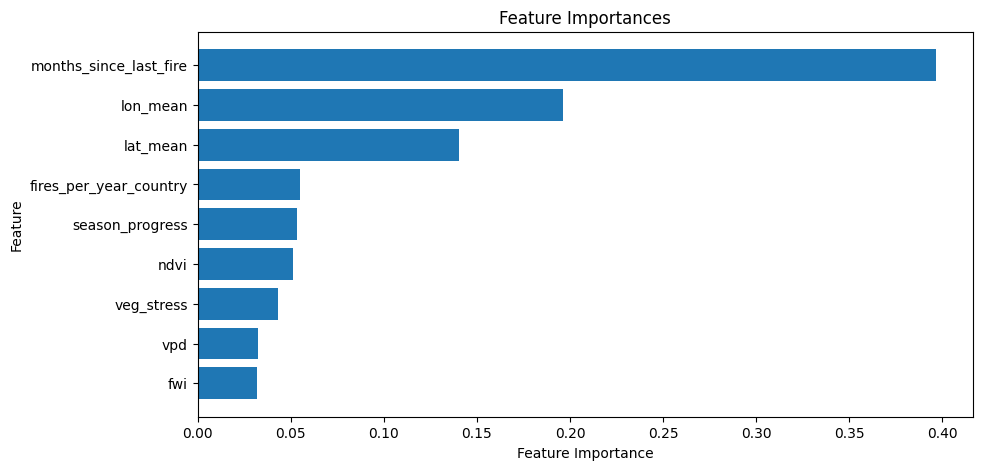

In [ ]:
#make visual of the feature importances
plt.figure(figsize=(10,5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # most important at top
plt.show()

### Gradient Boosting

In [ ]:
#train gbc
gbc = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

#fit gbc
gbc.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=10,
                               random_state=42)

In [ ]:
#accurancy on training set (gb)
gbc.score(X_train, y_train)

0.6110153523548649

In [ ]:
#get gb predictions
y_pred_gbc = gbc.predict(X_test)

In [ ]:
#evaluate gb
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))

Accuracy: 0.6105911478775436


The use of these 3 additional parameters saw no improvement to the model:
- min_samples_leaf=20      
- L2_regularization=1.0
- class_weight='balanced (this one lowered accuracy)

In [ ]:
#classification report for gbc
print("\n Gradient Boost Classification Report:\n", classification_report(y_test, y_pred_gbc, target_names=['small', 'medium', 'big']))


 Gradient Boost Classification Report:
               precision    recall  f1-score   support

       small       0.65      0.86      0.74    207516
      medium       0.50      0.33      0.40    133454
         big       0.46      0.03      0.06     23372

    accuracy                           0.61    364342
   macro avg       0.53      0.41      0.40    364342
weighted avg       0.58      0.61      0.57    364342



An almost identical classification report to decision tree

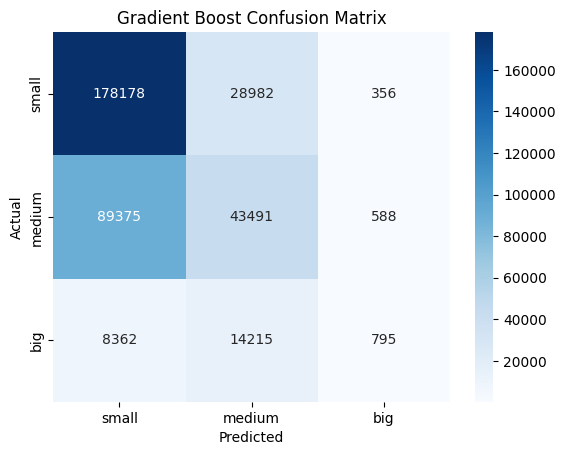

In [ ]:
#confusion matrix for gbc
cm = confusion_matrix(y_test, y_pred_gbc)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Confusion Matrix')
plt.show()

### Gradient Boost with Class Weight Parameter

In [ ]:
#train gbc
gbc2 = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=10,
    class_weight = 'balanced',
    random_state=42
)

#fit gbc
gbc2.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.05,
                               max_depth=10, random_state=42)

In [ ]:
#get gb predictions
y_pred_gbc2 = gbc2.predict(X_test)

In [ ]:
#classification report for gbc
print("\n Gradient Boost (cw) Classification Report:\n", classification_report(y_test, y_pred_gbc2, target_names=['small', 'medium', 'big']))


 Gradient Boost (cw) Classification Report:
               precision    recall  f1-score   support

       small       0.69      0.69      0.69    207516
      medium       0.46      0.24      0.32    133454
         big       0.19      0.71      0.30     23372

    accuracy                           0.52    364342
   macro avg       0.45      0.55      0.43    364342
weighted avg       0.57      0.52      0.53    364342



- Recall on big fires is high (0.71) - model successfully identifies most high-severity fires

- Precision for big fires is low (0.19) - tends to over-predict big fires (false alarms)

- Medium fires are difficult to classify (recall 0.24), which suggests overlap in feature patterns

- Overall accuracy is moderate (0.52), but the model performs best in terms of safety, making it the strongest choice for prioritizing detection of big fires

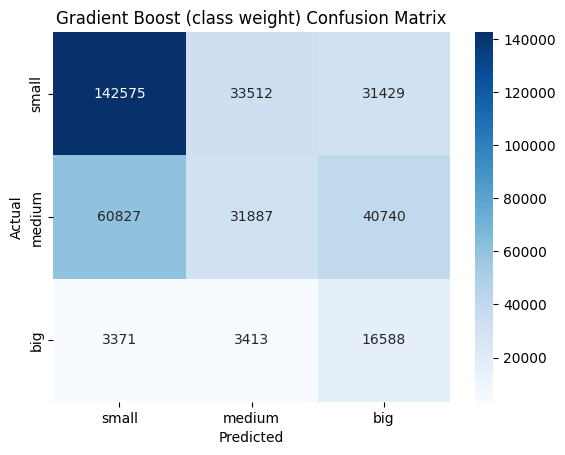

In [ ]:
#confusion matrix for gbc2
cm = confusion_matrix(y_test, y_pred_gbc2)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['small', 'medium', 'big'],
            yticklabels=['small', 'medium', 'big'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost (class weight) Confusion Matrix')
plt.show()

## Model Comparison

In [ ]:
#compare models by accuracy and F1 scores
results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    #"F1 (macro)": f1_score(y_test, y_pred_lr, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_lr, labels=[2], average='macro'),
    #"Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_lr)
})

# Decision Tree
results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "F1 (macro)": f1_score(y_test, y_pred_dt, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_dt, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_dt)
})

# Decision Tree (with class weight)
results.append({
    "Model": "Decision Tree (class weight)",
    "Accuracy": accuracy_score(y_test, y_pred_dt2),
    "F1 (macro)": f1_score(y_test, y_pred_dt2, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_dt2, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_dt2)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "F1 (macro)": f1_score(y_test, y_pred_rf, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_rf, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_rf)
})

# Random Forest (with class weight)
results.append({
    "Model": "Random Forest (class weight)",
    "Accuracy": accuracy_score(y_test, y_pred_rf2),
    "F1 (macro)": f1_score(y_test, y_pred_rf2, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_rf2, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_rf2)
})

# Gradient Boosting
results.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy_score(y_test, y_pred_gbc),
    "F1 (macro)": f1_score(y_test, y_pred_gbc, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_gbc, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_gbc)
})

# Gradient Boosting (with class weight)
results.append({
    "Model": "Gradient Boosting (class weight)",
    "Accuracy": accuracy_score(y_test, y_pred_gbc2),
    "F1 (macro)": f1_score(y_test, y_pred_gbc2, average='macro'),
    "Recall (big)": recall_score(y_test, y_pred_gbc2, labels=[2], average='macro'),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_gbc2)
})

comparison_df = pd.DataFrame(results).sort_values(by="Recall (big)", ascending=False)
comparison_df


,Model,Accuracy,Recall (big)
4,Random Forest (class weight),0.516141,0.722874
6,Gradient Boosting (class weight),0.524370,0.709738
2,Decision Tree (class weight),0.516707,0.695619
0,Logistic Regression,0.412083,0.494352
1,Decision Tree,0.607388,0.080695
5,Gradient Boosting,0.610591,0.034015
3,Random Forest,0.608791,0.022292


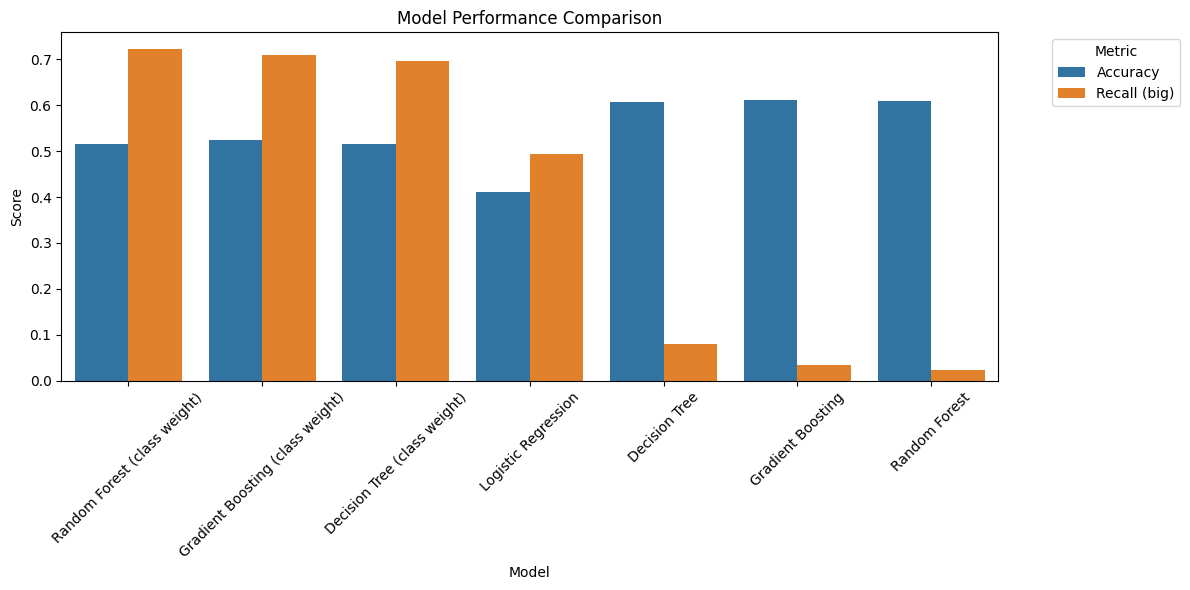

In [ ]:
#visualize the comparison
plt.figure(figsize=(12,6))
sns.barplot(
    data=comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)

# move legend outside plot area
plt.legend(
    title="Metric",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


Metrics Used:

Accuracy – overall percent of correct predictions (misleading in this case because small class dominates)

Balanced Accuracy – average recall across all classes
 - measures how fairly the model predicts each class
 - 0.33 is random guessing

Macro F1 – combines precision and recall for each class equally
(penalizes the model if it ignores big fires/smallest class)

Recall (on big fires) - shows how well this model captured all instances of this specific class. Big fires was used since their being misclassified held the biggest repurcussions

Analysis:

- All models with class imabalance have similar accuracy (~0.6) — just slightly better than predicting “small” for every fire (since 57% of fires are small)

- All modles where the class weight is balanced has an accuracy around 52%, while this is a less desirable accuracy, these models have a much higher recall for big fires (~70%)

- Given than false negatives are the most deterimental for this specific problem, the models where the classes has been balanced are more reliable.

- Gradient Boost is most effective at capturing the big fire class while still having some predictive power for medium sized fires (the hardest to classify)

Takeaways:

- Models are biased toward predicting “small” fires and rarely predict “large”. When this is adjusted for with the class_weight parameter, accuracy suffers. However, since false negatives carry more risk, it it better for the model to have stronger recall on big fires than overall accuracy if that accuracy only means it is bias towards the largest class (small fires). Given this, Gradient Boost is the most successful model.

# Conclusion

After reviewing the feature importances accross these models, it is evident that the model draws most of its predictive power from the engineered variables rather than from the weather or vegetation indicators. The most influential features were months since last fire, longitude, latitude, season progress, and fires per year by country. In contrast, the weather and vegetation features — FWI, NDVI, VPD, and vegetation stress — had relatively low importance scores.

This suggests that the model is not gaining significant benefit from the aggregated weather and vegetation data currently used. A major limitation is that these variables are aggregated at the country-year level, meaning that areas with very different climates (for example, Alaska and Texas) share the same weather profile. Ideally, the dataset would include location-specific weather data that captures climatic variation more accurately, without relying on national boundaries.

Although the dataset’s structure limits model performance, the current models  do appear to capture some meaningful relationships between fire frequency, seasonal timing, and fire size. This indicates that there is real potential for improvement with more detailed and geographically precise data.

#### Key Takeaways

- The model’s strongest predictors are engineered features related to fire frequency and seasonal progress, not aggregated climate data

- Country-level aggregation masks regional climate differences, limiting the model’s ability to learn from weather and vegetation patterns

- The mensemble methods, particularly Gradient Boost with class weight as a parameter, still captures some meaningful relationships between fire timing and size, suggesting the approach is promising

- Improved performance will likely depend on more granular, location-specific environmental data as well as continuing to address class imbalance to ensure that the model captures the most severe cases of wildfire.

#### Suggestions for Further Study

- Incorporate more specific weather data (e.g., grid-based temperature, precipitation, humidity, wind speed)

- Explore spatial clustering or regional grouping methods that reflect ecological zones rather than country borders

- Potentially focus efforts on one part of the world where data is more readily available first to refine the approach, then generalize globally if successful

- After building a more successful model, the target variable, which is currently built off of area burned, could be made more robust by including additional markers of severity such as FRP, dnbr, and duration of fire.